## NLP: Analyzing Healthcare Reviews and Predicting Their Useful Votes

In [1]:
import os
import codecs
import json
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

data_directory = os.path.join('C:/Users/andre/Documents/', 'yelp_dataset_challenge_round9')
businesses_filepath = os.path.join(data_directory, 'yelp_academic_dataset_business.json')
review_json_filepath = os.path.join(data_directory, 'yelp_academic_dataset_review.json')
intermediate_directory = os.path.join(data_directory, 'intermediate')
review_txt_filepath = os.path.join(intermediate_directory, 'review_text_all.txt')

In [2]:
healthcare_ids = []

# open the businesses file
with codecs.open(businesses_filepath, encoding='utf_8') as f:
    
    # iterate through each line (json record) in the file
    for business_json in f:
        
        # convert the json record to a Python dict
        business = json.loads(business_json)
        
        # if this business has no categories or is not a target entity, skip to the next one
        if business[u'categories'] is None or u'Health & Medical' not in business[u'categories']:
            continue
        # Remove businesses in BW, Germany
        if u'BW' in business[u'state']:
            continue
        # Remove businesses that are restaurants, food and pets
        if u'Restaurants' in business[u'categories'] or u'Food' in business[u'categories'] or 'Pets' in business[u'categories']:
            continue
            
        # add the business id to our healthcare_ids set
        healthcare_ids.append(business[u'business_id'])

# Turn the list of ids into a set, which is faster for testing whether an element is in the set
healthcare_ids = set(healthcare_ids)

# print the number of unique ids in the dataset
print ('{:,}'.format(len(healthcare_ids)), u'health & medical entities in the dataset.')

10,211 health & medical entities in the dataset.


In [14]:
# Create a new file that contains only the text from reviews about healthcare entities.
# One review per line in the this new file.
    
review_count = 0
useful = []
stars = []

# create & open a new file in write mode
with codecs.open(review_txt_filepath, 'w', encoding='utf_8') as review_txt_file:

    # open the existing review json file
    with codecs.open(review_json_filepath, encoding='utf_8') as review_json_file:

        # loop through all reviews in the existing file and convert to dict
        for review_json in review_json_file:
            review = json.loads(review_json)

            # if this review is not in the target set, skip to the next one
            if review[u'business_id'] not in healthcare_ids:
                continue

            # write each review as a line in the new file
            # escape newline characters in the original review text
            if review[u'text'] is None:
                print(review_count)
            
            review_txt_file.write(review[u'text'].replace('\n', '\\n').replace('\r','') + '\n')
            review_count += 1
            useful.append(review[u'useful'])
            stars.append(review[u'stars'])

print (u'Text from {:,} healthcare reviews written to the new txt file.'.format(review_count))

Text from 114,556 healthcare reviews written to the new txt file.


### Preprocessing the Text

Use spaCy to tokenize, lemmitize and remove stopwords from the text. Apply phrase modeling by looking for words that tend to appear one after another more frequently than by random chance.

In [3]:
import spacy
import pandas as pd
import itertools as it

nlp = spacy.load('en')

In [4]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

unigram_sentences_filepath = os.path.join(intermediate_directory, 'unigram_sentences_all.txt')
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')
bigram_sentences_filepath = os.path.join(intermediate_directory, 'bigram_sentences_all.txt')
trigram_model_filepath = os.path.join(intermediate_directory, 'trigram_model_all')
trigram_sentences_filepath = os.path.join(intermediate_directory, 'trigram_sentences_all.txt')
trigram_reviews_filepath = os.path.join(intermediate_directory, 'trigram_transformed_reviews_all.txt')

In [6]:
def punct_space(token):
    """Eliminate tokens that are pure punctuation or white space"""
    
    return token.is_punct or token.is_space

def person(token):
    """Remove tokens that are PERSON entities"""
    
    return token.ent_type_ == 'PERSON'

def line_review(filename):
    """Generator function (iterator without storing all texts)
    to read in reviews from file and return the original line breaks"""
    
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')

def lemmatized_sentence_corpus(filename):
    """Generator function to use spaCy to parse reviews, lemmatize the text and yield sentences"""
    
    for parsed_review in nlp.pipe(line_review(filename), batch_size=10000, n_threads=4):
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent 
                             if not (punct_space(token) or person(token))])

In [7]:
# Segment reviews into sentences and normalize the text
# Save the parsed sentences file on disk to avoid storing the entire corpus in RAM
if 1 == 1:
    with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus(review_txt_filepath):
            f.write(sentence + '\n')

In [8]:
# gensim's LineSentence class takes the format: one sentence = one line
# words are preprocessed and separated by whitespace.
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [9]:
# Run a phrase model to link two-words phrases together
if 1 == 1:
    bigram_model = Phrases(unigram_sentences)
    bigram_model.save(bigram_model_filepath)

else:
    bigram_model = Phrases.load(bigram_model_filepath)

In [10]:
# Apply the bigram model to unigram sentences and create a text with bigram sentences
if 1 == 1:
    with codecs.open(bigram_sentences_filepath, 'w', encoding='utf-8') as f:
        for unigram_sentence in unigram_sentences:
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            f.write(bigram_sentence + '\n')

In [11]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [12]:
if 1 == 1:
    trigram_model = Phrases(bigram_sentences)
    trigram_model.save(trigram_model_filepath)
else:
    trigram_model = Phrases.load(trigram_model_filepath)

In [13]:
if 1 == 1:
    with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for bigram_sentence in bigram_sentences:
            trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            f.write(trigram_sentence + '\n') 

In [5]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [15]:
# Write a transformed text into a new file, with one review per line
if 1 == 1:
    with codecs.open(trigram_reviews_filepath, 'w', encoding='utf-8') as f:
        for parsed_review in nlp.pipe(line_review(review_txt_filepath), batch_size=10000, n_threads=4):
            
            # Lemmatize the text, removing punctuation and whitespace
            unigram_review = [token.lemma_ for token in parsed_review 
                              if not (punct_space(token))]
            
            # Apply the first-order and second-order phrase models
            bigram_review = bigram_model[unigram_review]
            trigram_review = trigram_model[bigram_review]
            
            # Remove any remaining stopwords
            trigram_review = [term for term in trigram_review 
                              if term not in spacy.en.language_data.STOP_WORDS]
            
            # Write the transformed review as a new line
            trigram_review = u' '.join(trigram_review)
            f.write(trigram_review + '\n')

### Train a Word2Vec Model

In [6]:
from gensim.models import Word2Vec
word2vec_filepath = os.path.join(intermediate_directory, 'word2vec_model_all')

In [7]:
if 0 == 1:
    # Train a word2vec model: 300-dimensional word vectors
    word2vec = Word2Vec(size=300, window=5, min_count=20, sg=0, workers=4)
    word2vec.build_vocab(trigram_sentences) 
    for epoch in range(10):
        word2vec.train(trigram_sentences)
    word2vec.save(word2vec_filepath)

word2vec = Word2Vec.load(word2vec_filepath)

In [8]:
print(u'{:,} terms in the word2vec vocabulary.'.format(len(word2vec.wv.vocab)))

11,242 terms in the word2vec vocabulary.


In [9]:
# build a list of terms, index, and term counts from the word2vec model
ordered_vocab = [(term, vocab.index, vocab.count) for term, vocab in word2vec.wv.vocab.items()]
ordered_vocab = sorted(ordered_vocab, key=lambda ordered_vocab:ordered_vocab[2], reverse=True)
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

In [10]:
# Creat a dictionary mapping each word to a 300-dimensional vector
word_vectors = dict(list(zip(word2vec.wv.index2word, word2vec.wv.syn0)))

In [14]:
word2vec.most_similar(positive=['dentist'], topn=5)

[('pediatric_dentist', 0.6470401287078857),
 ('orthodontist', 0.6364657878875732),
 ('chiropractor', 0.6113377809524536),
 ('dermatologist', 0.6081831455230713),
 ('doctor', 0.6010243892669678)]

In [19]:
word2vec.most_similar(positive=['dentist', 'baby'], negative=['tooth'],topn=5)

[('pediatrician', 0.49545931816101074),
 ('obgyn', 0.4893958270549774),
 ('doctor', 0.48449233174324036),
 ('ob', 0.4684830904006958),
 ('gyno', 0.46404534578323364)]

### Predictive Modeling with Document Features Created from Word2Vec 

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer
from collections import defaultdict
from tabulate import tabulate

In [15]:
useful = np.array(useful)
luseful = np.log(useful+1)
X = []
with codecs.open(trigram_reviews_filepath, encoding='utf-8') as f:
    for review in f:
        X.append(review)

In [16]:
class MeanEmbeddingVectorizer():
    """ Given a word to vector mapping, vectorize texts 
    by taking the mean of all the word vectors for each document"""
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(list(word2vec.values())[0])
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in review if w in self.word2vec] 
                   or [np.zeros(self.dim)], axis=0) 
                   for review in X])

In [17]:
class TfidfMeanVectorizer():
    """ Weight average word vector features by its tf-idf"""
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(list(word2vec.values())[0])
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x:x)
        tfidf.fit(X)
        # Let an unseem word be as infrequent as the most infreqeunt word
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] * self.word2weight[w]
                                 for w in review if w in self.word2vec] or 
                                [np.zeros(self.dim)], axis=0) 
                         for review in X])   

In [33]:
def cv_score(model, X, y, cv, scoring):
    scores = []
    for train, test in KFold(cv).split(X):
        model.fit(X[train], y[train])
        scores.append(scoring(y[test], model.predict(X[test])))
    return np.array(scores)

def RMSE(y_true, y_pred):
    """ Root Mean Squared Error"""
    return np.sqrt(np.mean((y_true - y_pred)**2))

def RMSLE(y_true, y_pred):
    """ Root Mean Squared Logarithmic Error"""
    return np.sqrt(np.mean(((np.log(y_true + 1) - np.log(y_pred + 1))**2)))


In [27]:
lr_w2v = Pipeline([("w2v_vectorizer", MeanEmbeddingVectorizer(word_vectors)), 
                   ("lr", LinearRegression())])
lr_w2v_tfidf = Pipeline([("tfidf_w2v_vectorizer", TfidfMeanVectorizer(word_vectors)),
                        ("lr", LinearRegression())])
gbr_w2v = Pipeline([("w2v_vectorizer", MeanEmbeddingVectorizer(word_vectors)),
                    ("gbr", GradientBoostingRegressor(n_estimators=100))])
gbr_w2v_tfidf = Pipeline([("tfidf_w2v_vectorizer", TfidfMeanVectorizer(word_vectors)),
                    ("gbr", GradientBoostingRegressor(n_estimators=100))])
etr_w2v = Pipeline([("w2v_vectorizer", MeanEmbeddingVectorizer(word_vectors)),
                    ("etr", ExtraTreesRegressor(n_estimators=100))])
etr_w2v_tfidf = Pipeline([("tfidf_w2v_vectorizer", TfidfMeanVectorizer(word_vectors)),
                    ("etr", ExtraTreesRegressor(n_estimators=100))])

In [28]:
lasso_w2v = Pipeline([("w2v_vectorizer", MeanEmbeddingVectorizer(word_vectors)), 
                   ("lasso", Lasso(alpha=1))])
lasso_w2v_tfidf = Pipeline([("tfidf_w2v_vectorizer", TfidfMeanVectorizer(word_vectors)),
                        ("lasso", Lasso(alpha=1))])
ridge_w2v = Pipeline([("w2v_vectorizer", MeanEmbeddingVectorizer(word_vectors)),
                    ("ridge", Ridge(alpha=1))])
ridge_w2v_tfidf = Pipeline([("tfidf_w2v_vectorizer", TfidfMeanVectorizer(word_vectors)),
                    ("ridge", Ridge(alpha=1))])
sgd_w2v = Pipeline([("w2v_vectorizer", MeanEmbeddingVectorizer(word_vectors)),
                    ("sgd", SGDRegressor())])
sgd_w2v_tfidf = Pipeline([("tfidf_w2v_vectorizer", TfidfMeanVectorizer(word_vectors)),
                    ("sgd", SGDRegressor())])

In [29]:
w2v_models = [("lr_w2v", lr_w2v), ("lr_w2v_tfidf", lr_w2v_tfidf),
              ("gbr_w2v", gbr_w2v), ("gbr_w2v_tfidf", gbr_w2v_tfidf),
              ("etr_w2v", lr_w2v), ("etr_w2v_tfidf", lr_w2v_tfidf),
             ("lasso_w2v", lasso_w2v), ("lasso_w2v_tfidf", lasso_w2v_tfidf),
              ("ridge_w2v", ridge_w2v), ("ridge_w2v_tfidf", ridge_w2v_tfidf),
              ("sgd_w2v", sgd_w2v), ("sgd_w2v_tfidf", sgd_w2v_tfidf)]

In [ ]:
w2v_rmse = sorted([(name, np.sqrt(np.mean(np.multiply(cross_val_score(
    model, X, luseful, cv=5, scoring='neg_mean_squared_error'), -1)))) 
                     for name, model in w2v_models], key=lambda x:x[1])

print (tabulate(w2v_rmse, floatfmt=".4f", headers=("model", "RMSE_5cv")))

### Predictive Modeling with Doc2Vec Features

In [21]:
# Gensim's Doc2Vec class creates vector representations for entire documents
# The input object is an iterator of LineSentence objects
# The default dm=1 refers to the distributed memory algorithm
# The algorithm runs through sentences twice: (1) build the vocab, 
# (2) learn a vector representation for each word and for each label (sentence)
# Better results can be achieved by iterating over the data several times

from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
doc2vec_filepath = os.path.join(intermediate_directory, 'doc2vec_model')

In [22]:
labels = ['Review_' + str(x) for x in range(len(X))]

In [23]:
class DocIterator():
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc.split(), tags=[self.labels_list[idx]])

In [24]:
labeled_reviews = DocIterator(X, labels)

In [25]:
# To produce better results, iterate over the data 10 times
# and control the learning rate for each iteration
if 0 == 1:
    doc2vec = Doc2Vec(size=100, alpha=0.025, min_alpha=0.025, window=8, min_count=5, workers=4, iter=10)
    doc2vec.build_vocab(labeled_reviews)

    for epoch in range(10):
        doc2vec.train(labeled_reviews)
        doc2vec.alpha -= 0.002
        doc2vec.min_alpha = doc2vec.alpha
    
    doc2vec.save(doc2vec_filepath)
    doc2vec.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
doc2vec = Doc2Vec.load(doc2vec_filepath)

In [32]:
doc2vec.most_similar(positive=["pediatrician"], topn=5)

[('ob', 0.7404353618621826),
 ('pcp', 0.7138863801956177),
 ('obgyn', 0.7098487019538879),
 ('ob/gyn', 0.7045339941978455),
 ('primary_care_physician', 0.6940240859985352)]

In [33]:
doc2vec.most_similar(positive=['pediatrician','tooth'], negative=['baby'], topn=5)

[('dentistry', 0.54587322473526),
 ('pediatric_dentist', 0.5437402129173279),
 ('dentist', 0.5426872372627258),
 ('wisdom_tooth', 0.5292142629623413),
 ('teeth', 0.5250543355941772)]

In [34]:
doc2vec.docvecs.most_similar('Review_10', topn=5)

[('Review_70758', 0.4582338333129883),
 ('Review_108741', 0.4582274556159973),
 ('Review_40339', 0.45029744505882263),
 ('Review_100556', 0.43604543805122375),
 ('Review_68671', 0.43078291416168213)]

In [30]:
lr_d2v = Pipeline([("lr", LinearRegression())])
gbr_d2v = Pipeline([("gbr", GradientBoostingRegressor(n_estimators=200))])
etr_d2v = Pipeline([("etr", ExtraTreesRegressor(n_estimators=200))])
d2v_models = [("lr_d2v", lr_d2v), ("gbr_d2v", gbr_d2v), ("etr_d2v", etr_d2v)]

In [ ]:
d2v_rmse = [(name, np.sqrt(np.mean(np.multiply(cross_val_score(
    model, np.array(doc2vec.docvecs), luseful, cv=5, scoring='neg_mean_squared_error'), -1)))) 
              for name, model in d2v_models]

In [ ]:
rmse = sorted(w2v_rmse + d2v_rmse, key=lambda x:x[1])

print (tabulate(rmse, floatfmt=".4f", headers=("model", "RMSE_5cv")))

### Predicting Review Usefulness Based on the Amount of Training Data

In [26]:
def benchmark(model, X, y, n):
    ss = ShuffleSplit(n_splits=5, test_size = 1 - n, random_state=0)
    scores = []
    for train, test in ss.split(X,y):
        scores.append(RMSE(y[test], model.fit(X[train],y[train]).predict(X[test])))
    return np.mean(scores)

In [34]:
train_sizes = [0.3, 0.5, 0.7]
table = []
'''for name, model in w2v_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'RMSE': benchmark(model, np.array(X), luseful, n),
                      'train_size': n})'''
for name, model in d2v_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'RMSE': benchmark(model, np.array(doc2vec.docvecs), luseful, n),
                      'train_size': n})
df = pd.DataFrame(table)

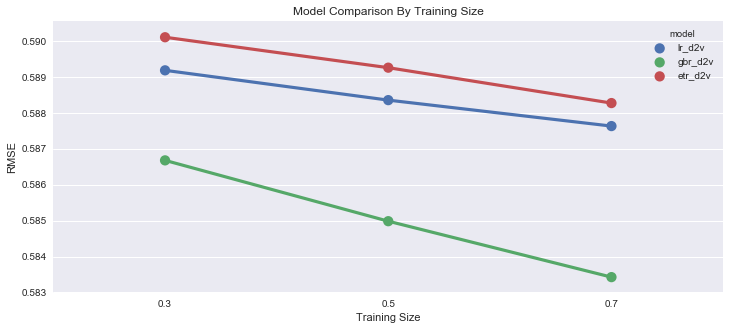

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,5))
fig = sns.pointplot(x='train_size', y='RMSE', hue='model',
                   data=df)#[df.model.map(lambda x: x in ['gbr_w2v_tfidf','gbr_d2v', 'etr_w2v_tfidf', 'etr_d2v'])])
sns.set_context('notebook')
sns.set_style('white')
fig.set(ylabel='RMSE')
fig.set(xlabel='Training Size')
fig.set(title='Model Comparison By Training Size')
plt.show()